# 1. Importando as Libs

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

## 1.1 Funções

In [2]:
def analyze_variable(dataframe, variable, target): 
  #dataframe[target] = dataframe[target].astype('int64')

  # Se a variável for numérica, arredonda para 4 casas decimais
  if pd.api.types.is_numeric_dtype(dataframe[variable].dtypes) == True and pd.api.types.is_bool_dtype(dataframe[variable].dtypes) == False:
      dataframe[variable] = dataframe[variable].round(4)
      dataframe[variable] = dataframe[variable].astype(str)

  # Calcula a taxa de evento e o volume para cada categoria da variável
  result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
  result.columns = [variable, 'Taxa_de_Evento', 'Volume']

  # Ordena o resultado pela Taxa de Evento em ordem decrescente
  result = result.sort_values(by='Taxa_de_Evento', ascending=False)

  # Plota o gráfico
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Eixo Y esquerdo: Volume
  bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento
  ax2 = ax1.twinx()
  lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
  plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
  labels = [plot.get_label() for plot in plots]
  plt.legend(plots, labels, loc='upper left')

  plt.title(f'Volume e Taxa de Evento por {variable}')
  plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
  plt.tight_layout()
  plt.show()

  return result

# 2. Obtendo os dados

In [3]:
# lendo o arquivo contendo os dados de treino
df_raw = pd.read_csv('C:\\Users\\done_\\OneDrive\\Documentos\\Kaggle\\train.csv')

## 2.1 Separando em Dados de Treino e Teste

In [4]:
from sklearn.model_selection import train_test_split

# atributos explicativas
df_expl = df_raw.drop(columns = ['Survived'])

# atributos dependentes
df_dep = df_raw[['Survived']]

# separando em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_expl, df_dep, test_size = 0.30, random_state=42)

# concatenando os dados de treino
df_train = pd.concat([X_train, y_train], axis=1)

In [5]:
# visualizando as cinco primeiras entradas
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
445,446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,1
650,651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S,0
172,173,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S,1
450,451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S,0
314,315,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S,0


In [6]:
# visualizando o formato do DataFrame
print('Visualizando o formato dos dados de treino.\n')

print(f'Quantidade de Linhas: {df_train.shape[0]}')
print(f'Quantidade de Características: {df_train.shape[1]}')

Visualizando o formato dos dados de treino.

Quantidade de Linhas: 623
Quantidade de Características: 12


In [7]:
# visualizando o tipo de dado e o preenchimento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 445 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  623 non-null    int64  
 1   Pclass       623 non-null    int64  
 2   Name         623 non-null    object 
 3   Sex          623 non-null    object 
 4   Age          499 non-null    float64
 5   SibSp        623 non-null    int64  
 6   Parch        623 non-null    int64  
 7   Ticket       623 non-null    object 
 8   Fare         623 non-null    float64
 9   Cabin        139 non-null    object 
 10  Embarked     622 non-null    object 
 11  Survived     623 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 63.3+ KB


* Os DataFrame com os dados de treino possui 12 atributos e 623 instâncias;
* Os atributos `PassengerId`, `Survived`, `Age`, `SibSp`, `Parch`,  e `Fare` são atributos númericos;
* Os atributos `Pclass`, `Name`, `Sex`, `Ticket`, `Cabin` e `Embarked` são atributos categóricos;
* O atributo `Survived`é o target e os demais atributos são as variáveis explicativas;
* A característica `Cabin` e `Age` possuem dados ausentes;
* Para a modelagem, iremos desconsiderar a característica `Cabin`, pois possui apenas 22% de preenchimento. Outros atributos com problema de preenchimento é o atributo `Age` com apenas 80% de preenchimento e o atributo `Embarked` com 99% de preenchimento.

## 2.2 Dícionario de Dados

`Survived:` Sobrevivência  
`Pclass:` Classe do bilhete  
`Sex:` Sexo  
`Age:` Idade em anos  
`SibSp:` # de irmãos/cônjuges a bordo do Titanic  
`Parch:` # de pais/filhos a bordo do Titanic  
`Ticket:` Número do bilhete  
`Fare:` Tarifa do passageiro  
`Cabin:` Número da cabine  
`Embarked:` Porto de embarque C = Cherbourg, Q = Queenstown, S = Southampton
pton







# 3. Análise Exploratória

In [8]:
df_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,623.000000,623.000000,499.000000,623.000000,623.000000,623.000000,623.000000
mean,446.581059,2.341894,29.256353,0.576244,0.386838,31.840730,0.370787
std,260.012799,0.819945,14.558567,1.216267,0.807692,51.027372,0.483404
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,216.000000,2.000000,20.000000,0.000000,0.000000,7.925000,0.000000
50%,454.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,675.500000,3.000000,38.000000,1.000000,0.000000,30.750000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


* A média de idade dos passageiros é de 29,69 anos, variando desde o passageiro mais jovem, com 0,42 anos, até o mais idoso, com 80 anos;
* Quanto ao atributo `Survived`, a média é de 0,38, sugerindo que apenas 38% dos passageiros conseguiram sobreviver.

## Pclass

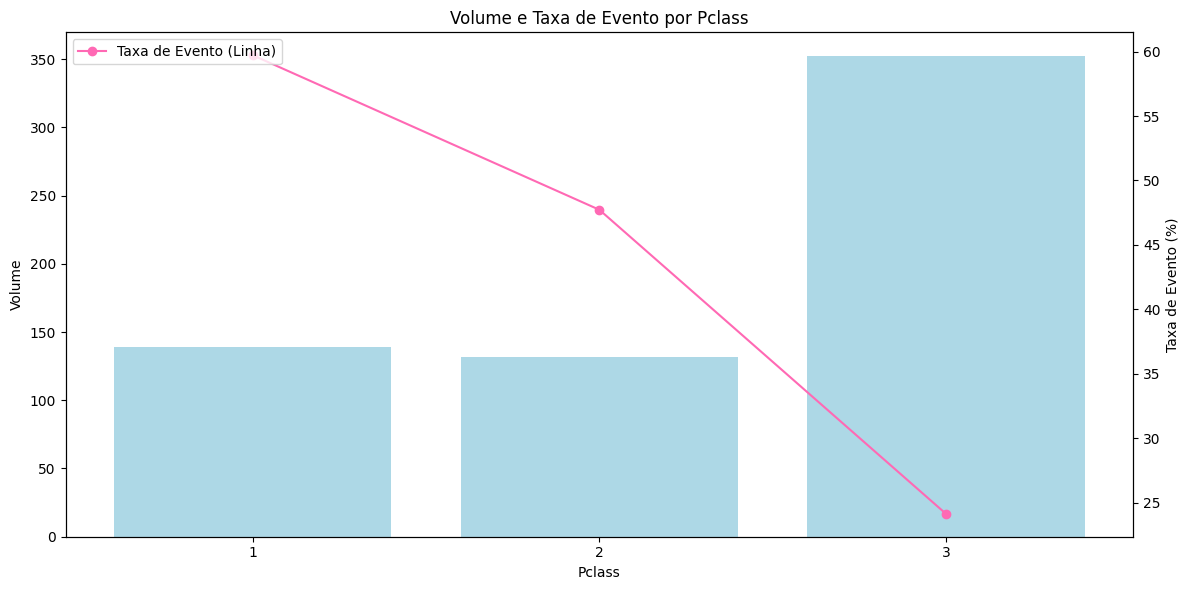

,Pclass,Taxa_de_Evento,Volume
0,1,0.597122,139
1,2,0.477273,132
2,3,0.241477,352


In [9]:
analyze_variable(df_train, 'Pclass', 'Survived')

* Ao examinar a distribuição dos passageiros em relação à classe e à variável alvo, fica evidente que os passageiros da terceira classe foram os que menos sobreviveram. Por outro lado, aproximadamente 62% dos passageiros da primeira classe conseguiram sobreviver.

## Sex

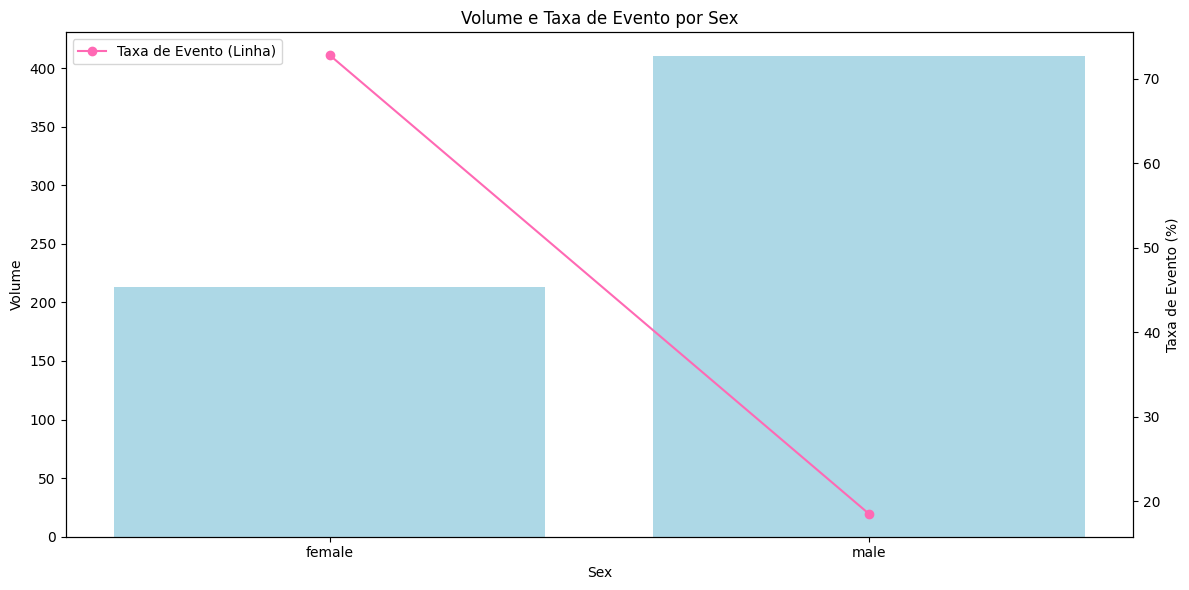

,Sex,Taxa_de_Evento,Volume
0,female,0.727700,213
1,male,0.185366,410


In [10]:
analyze_variable(df_train, 'Sex', 'Survived')

* Ao examinar a distribuição dos passageiros e a taxa de sobrevivência, torna-se evidente que a proporção de passageiros do sexo masculino superava a do sexo feminino. No entanto, é importante destacar que a quantidade de sobreviventes do sexo feminino foi superior à dos passageiros do sexo masculino.

## Age

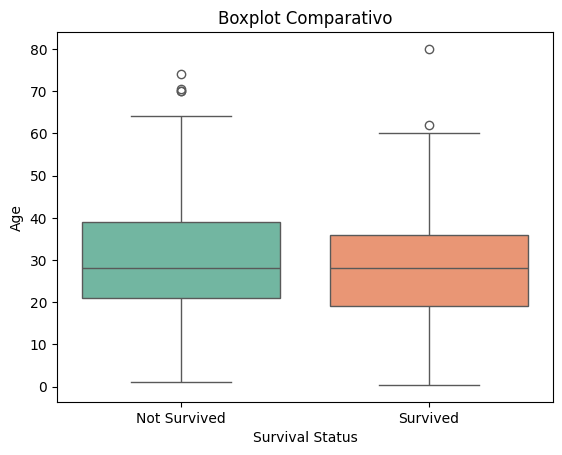

In [11]:
# Verificando a disribuição da caracteristica Age
df_combined = pd.concat([df_train[df_train['Survived'] == 0]['Age'], df_train[df_train['Survived'] == 1]['Age']], axis=1)
df_combined.columns = ['Not Survived', 'Survived']

sns.boxplot(data=df_combined, palette='Set2')

plt.title('Boxplot Comparativo')
plt.xlabel('Survival Status')
plt.ylabel('Age')

plt.show()

* A distribuição do atributo `Age` é praticamente a mesma em ambas as classes do target. Além disso, observa-se a presença de valores atípicos (outliers).

## SibSp

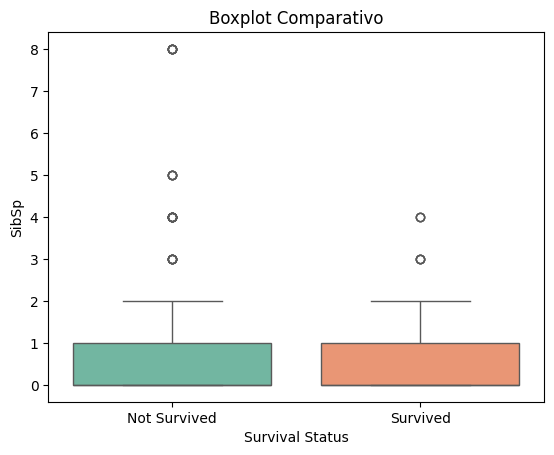

In [12]:
# Verificando a disribuição da caracteristica Age
df_combined = pd.concat([df_train[df_train['Survived'] == 0]['SibSp'], df_train[df_train['Survived'] == 1]['SibSp']], axis=1)
df_combined.columns = ['Not Survived', 'Survived']

sns.boxplot(data=df_combined, palette='Set2')

plt.title('Boxplot Comparativo')
plt.xlabel('Survival Status')
plt.ylabel('SibSp')

plt.show()

In [13]:
# resumo estatistico
df_train.SibSp.describe()

count    623.000000
mean       0.576244
std        1.216267
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

* Temos que 75% da base possui até um ou nenhum irmão/cônjuge a bordo do Titanic. A distribuição do atributo `SibSp` é praticamente a mesma em ambas as classes do target. Além disso, observa-se a presença de valores atípicos (outliers).

## Parch

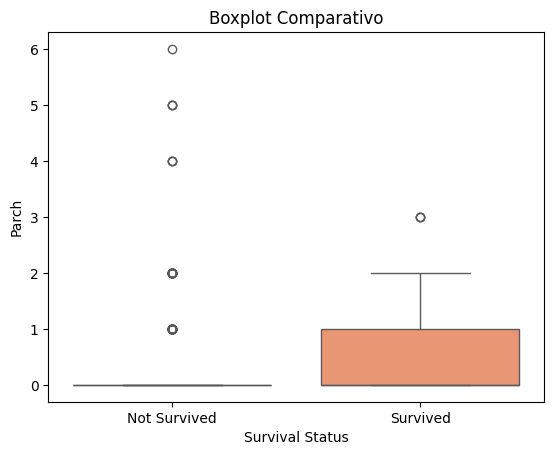

In [14]:
# Verificando a disribuição da caracteristica Age
df_combined = pd.concat([df_train[df_train['Survived'] == 0]['Parch'], df_train[df_train['Survived'] == 1]['Parch']], axis=1)
df_combined.columns = ['Not Survived', 'Survived']

sns.boxplot(data=df_combined, palette='Set2')

plt.title('Boxplot Comparativo')
plt.xlabel('Survival Status')
plt.ylabel('Parch')

plt.show()

In [15]:
# resumo estatistico
df_train.Parch.describe()

count    623.000000
mean       0.386838
std        0.807692
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

* Temos que 75% da base não possui nenhum pai/filho a bordo do Titanic. A análise da distribuição do atributo `Parch` em relação ao target indica que a maioria dos passageiros que não sobreviveram não tinha pais/filhos a bordo. No entanto, ao observar a distribuição dessa mesma variável para os sobreviventes, nota-se que uma pequena parcela deles tinha pais/filhos a bordo.

## Fare

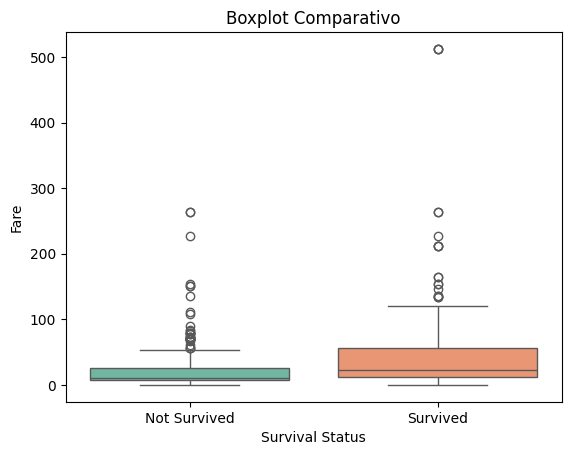

In [16]:
# Verificando a disribuição da caracteristica Age
df_combined = pd.concat([df_train[df_train['Survived'] == 0]['Fare'], df_train[df_train['Survived'] == 1]['Fare']], axis=1)
df_combined.columns = ['Not Survived', 'Survived']

sns.boxplot(data=df_combined, palette='Set2')

plt.title('Boxplot Comparativo')
plt.xlabel('Survival Status')
plt.ylabel('Fare')

plt.show()

In [17]:
# resumo estatistico
df_train.Fare.describe()

count    623.000000
mean      31.840730
std       51.027372
min        0.000000
25%        7.925000
50%       14.454200
75%       30.750000
max      512.329200
Name: Fare, dtype: float64

* Cerca de 75% dos passageiros a bordo do Titanic pagaram até 31 dólares em seus bilhetes. Apenas uma pequena parcela desembolsou uma quantia superior. Ao analisar a distribuição, parece que os passageiros que investiram mais dinheiro em seus bilhetes tiveram uma probabilidade maior de sobrevivência.

## Embarked

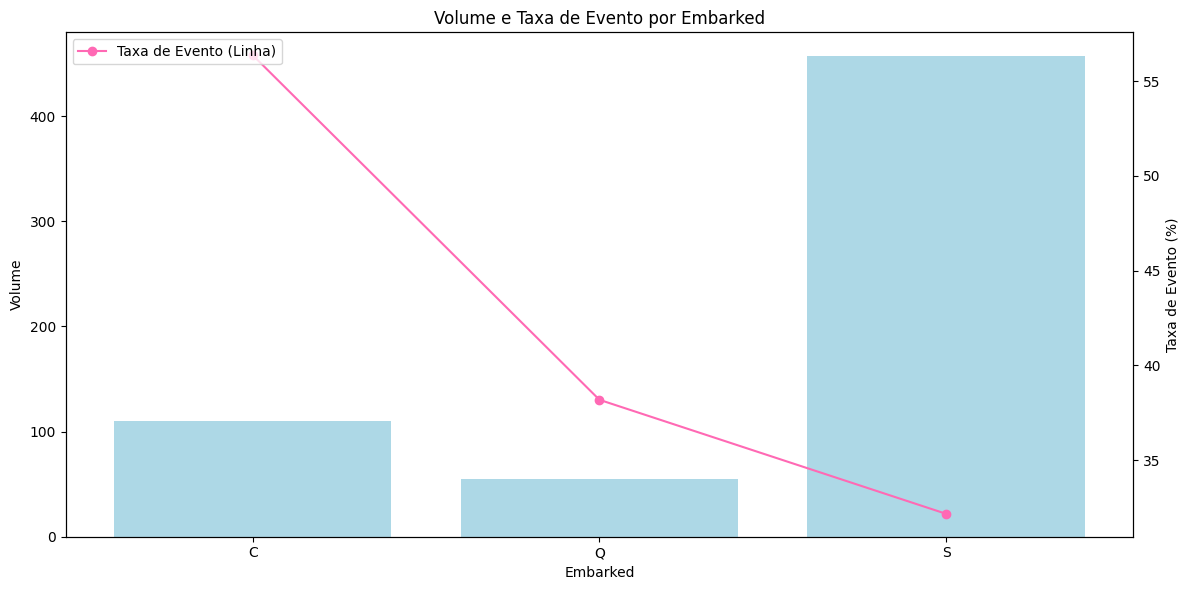

,Embarked,Taxa_de_Evento,Volume
0,C,0.563636,110
1,Q,0.381818,55
2,S,0.321663,457


In [18]:
analyze_variable(df_train, 'Embarked', 'Survived')

* Os passageiros do Titanic embarcaram em três portos, sendo que a maioria deles embarcou em Southampton, que apresentou a menor taxa de sobrevivência entre os portos de embarque.

# 4. Pré-Processamento

In [19]:
# pipeline para atributos numericos
num_feat = ['Age', 'Fare']
pre_processing_num_feat = Pipeline(
    steps = [
        ('Imputer', SimpleImputer(missing_values=np.nan, strategy ='median')),
        ('Scaler', StandardScaler())
    ]
)

# pipeline para atributos categoricos
cat_feat = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
pre_processing_cat_feat = Pipeline(
    steps = [
        ('Imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# pipeline para atributos categoricos one_hot
cat_feat_one_hot = ['Pclass', 'Sex', 'Embarked']
pre_processing_cat_feat_one_hot = Pipeline(
    steps = [
        ('One_Hot', OneHotEncoder())
    ]
)

# pré-processamento usando column transformer
pre_processing = ColumnTransformer([
    ('num_feat', pre_processing_num_feat, num_feat),
    ('cat_feat', pre_processing_cat_feat, cat_feat),
    ('one_hot_encoding', pre_processing_cat_feat_one_hot, cat_feat_one_hot),
], remainder='drop')

X_train_transformed = pre_processing.fit_transform(X_train)

X_train_transformed = pd.DataFrame(data = X_train_transformed, columns = pre_processing.get_feature_names_out())

# pipeline para atributos numericos
num_feat = ['Age', 'Fare']
pre_processing_num_feat = Pipeline(
    steps = [
        ('Imputer', SimpleImputer(missing_values=np.nan, strategy ='median')),
        ('Scaler', StandardScaler())
    ]
)

# pipeline para atributos categoricos
cat_feat = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
pre_processing_cat_feat = Pipeline(
    steps = [
        ('Imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# pipeline para atributos categoricos one_hot
cat_feat_one_hot = ['Pclass', 'Sex', 'Embarked']
pre_processing_cat_feat_one_hot = Pipeline(
    steps = [
        ('One_Hot', OneHotEncoder())
    ]
)

# pré-processamento usando column transformer
pre_processing = ColumnTransformer([
    ('num_feat', pre_processing_num_feat, num_feat),
    ('cat_feat', pre_processing_cat_feat, cat_feat),
    ('one_hot_encoding', pre_processing_cat_feat_one_hot, cat_feat_one_hot),
], remainder='drop')

X_train_transformed = pre_processing.fit_transform(X_train)

X_train_transformed = pd.DataFrame(data = X_train_transformed, columns = pre_processing.get_feature_names_out())

X_train_transformed.drop(columns = ['cat_feat__Pclass', 'cat_feat__Sex', 'cat_feat__Embarked', 'one_hot_encoding__Embarked_nan'], inplace = True)

# 5. Modelagem

## 5.1 LogisticRegression

### 5.1.1 Hyperparameter Tuning

In [20]:
# instanciando o objeto
lr = LogisticRegression()

param = {
    'penalty': ['l1', 'l2', 'elasticnet']
    , 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    , 'fit_intercept': [True, False]
    , 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# instanciando o objeto
gscv = GridSearchCV(lr, param_grid = param, cv = 5, verbose = True)

# fit do gridsearch
gscv.fit(X_train_transformed, y_train.values.ravel())

# visualizando os melhores parametros
gscv.best_params_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


{'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}

### 5.1.2 Treino

In [21]:
# instanciando o objeto com os parametros obtidos no gridsearch
lr = LogisticRegression(C = 0.1, fit_intercept = True, penalty = 'l2', solver = 'lbfgs')

# fit do modelo
lr.fit(X_train_transformed, y_train.values.ravel())

# predict nos dados de treino
y_train_predict = lr.predict(X_train_transformed)

In [22]:
report = classification_report(y_train.values.ravel(), y_train_predict)

# Exiba o relatório de classificação
print(report)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       392
           1       0.80      0.67      0.73       231

    accuracy                           0.81       623
   macro avg       0.81      0.78      0.79       623
weighted avg       0.81      0.81      0.81       623



### 5.1.3 Validação

In [23]:
# pre-processamento dos dados de teste
X_test_transformed = pre_processing.fit_transform(X_test)

X_test_transformed = pd.DataFrame(data = X_test_transformed, columns = pre_processing.get_feature_names_out())

X_test_transformed.drop(columns = ['cat_feat__Pclass', 'cat_feat__Sex', 'cat_feat__Embarked', 'one_hot_encoding__Embarked_nan'], inplace = True)

# predict nos dados de treino
y_test_predict = lr.predict(X_test_transformed)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.80      0.70      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



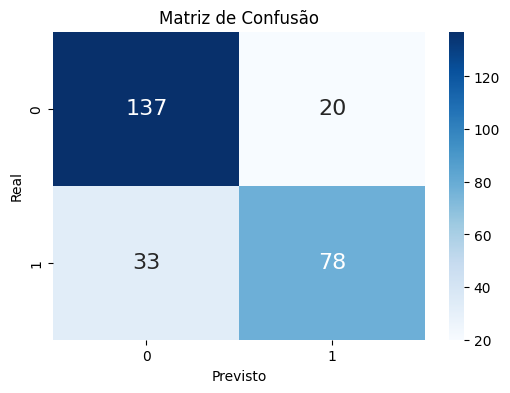

In [31]:
# relatorio de classificacao
report = classification_report(y_test.values.ravel(), y_test_predict)

print(report)

# matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [43]:
predicted = cross_val_predict(lr, X_test_transformed, y_test.values.ravel(), cv = 3)
accuracy_score(y_test.values.ravel(), predicted)

0.7873134328358209

### 5.1.4 Conclusões

O modelo apresenta um desempenho sólido, acertando aproximadamente 80,22% das previsões, com destaque para a identificação correta de cerca de 70% das instâncias positivas. A precisão das previsões positivas também é notável, atingindo 79,59%. Esses resultados indicam uma capacidade substancial do modelo em realizar classificações precisas.

Além disso, para validar a robustez do modelo, realizamos uma validação cruzada nos dados de teste, resultando em uma acurácia média de 78,73%. Esse processo de validação cruzada proporciona uma avaliaç da generalização do modelo.ão